# Librerías a usar

In [1]:
#Básicos
import pandas as pd
import numpy as np

#Graficar
import seaborn as sns
import matplotlib.pyplot as plt

#Sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import tree

#Imbalanced-learn
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

#Otros
from scipy import stats
import warnings

# Vista previa del dataset

In [3]:
#Creo una lista con los nombres de las columnas y cargo los datos
attributes = ["Elevation","Aspect","Slope","Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology","Horizontal_Distance_To_Roadways","Hillshade_9am","Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points","Rawah","Neota","Comanche_Peak","Cache_la_Poudre"]
for i in range(1,41):
    soil ="Soil_%d" %(i)
    attributes.append(soil)
attributes.append("Cover_Type")
data = pd.read_csv("covtype.data.gz",sep = ",", header = None, names = attributes)

In [4]:
data

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_32,Soil_33,Soil_34,Soil_35,Soil_36,Soil_37,Soil_38,Soil_39,Soil_40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


Como podemos ver, nuestro DataFrame consiste en una tabla de valores numéricos con **581012 muestras**, cada una representando una parcela de $90 m^2$.

Tenemos 55 columnas de las cuales podemos extraer **13 atributos**, ya que muchas de estas contienen valores binarios del mesmo atributo. Además, una de ellas se corresponde con el tipo de cobertura forestal que queremos predecir, por lo que usaremos algoritmos de aprendizaje automático **supervisados** para nuestra tarea.

Si nos fijamos en las columnas tenemos 2 que son: distancia horizontal a hidrología y distancia vertical. Dado que en tamaños tan pequeños de parcela no hay un cambio significativo de lalitud para que sea necesaria unha diferenciación, podemos juntar ambas columnas en una que sea directamente la distancia euclídea a una fuente de agua y así reduciremos de entrada la dimensionalidad en 1.

Aprovechamos de paso para crear una copia de nuestro DataFrame (df) con el que trabajaremos.

# Análise exploratorio de datos
## NOTA: En el caso de querer ejecutar la parte final del script relativa a los algoritmos de ML, no es necesario ejecutar las líneas de esta sección. Todo el código de esta sección sólo tiene la función de obtener información sobre los datos.

In [ ]:
df = data.copy() #Creamos copia

Text(0, 0.5, 'Tipos de dato')

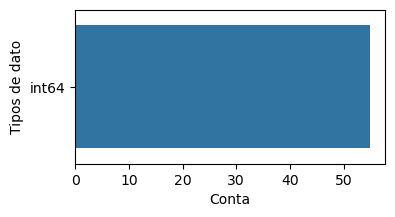

In [ ]:
#Graficamos los tipos de datos respecto el número de cada uno
plt.figure(figsize=(4,2))
sns.countplot(y=df.dtypes ,data=df)
plt.xlabel("Conta")
plt.ylabel("Tipos de dato")

In [ ]:
#Comprobamos si existe algún NaN en todo el DataFrame
df.isna().values.any()

False

Vamos a ver en primer lugar cómo se distribuye nuestro CoverType

In [ ]:
df["Cover_Type"].describe()

count    581012.000000
mean          2.051471
std           1.396504
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           7.000000
Name: Cover_Type, dtype: float64

<AxesSubplot: xlabel='Cover_Type', ylabel='Contas'>

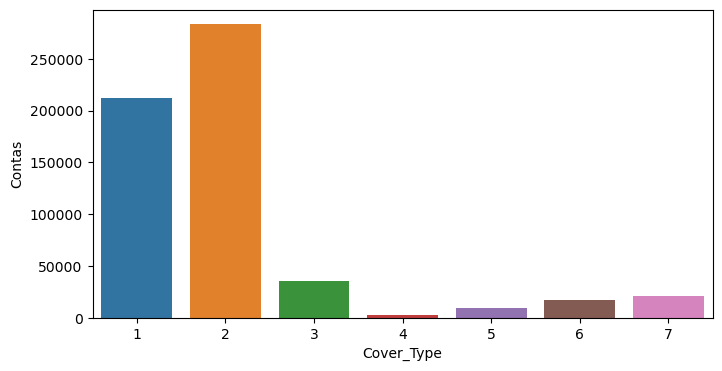

In [ ]:
class_dist=data.groupby('Cover_Type').size()
class_label=pd.DataFrame(class_dist,columns=['Contas'])
plt.figure(figsize=(8,4))
sns.barplot(x=class_label.index,y=class_label.Contas,data=class_label)

Vamos a separar en primer lugar nuestro dataset en 5 distintos: 1 con las columnas continuas (más otro igual con la columna de Cover_Type), 1 con las columnas binarias, 1 con las columnas da área silvestre y 1 con los tipos de suelo.

In [ ]:
cont_data=data.loc[:,'Elevation':'Horizontal_Distance_To_Fire_Points']

cont_data_cover = cont_data.copy()
cont_data_cover['Cover_Type'] = data['Cover_Type']

binary_data=data.loc[:,'Rawah':'Soil_40']

Wilderness_data=data.loc[:,'Rawah': 'Cache_la_Poudre']

Soil_data=data.loc[:,'Soil_1':'Soil_40']

Vamos a comprobar cómo se distribuyen nuestros datos.

CPU times: total: 42 s
Wall time: 35.4 s


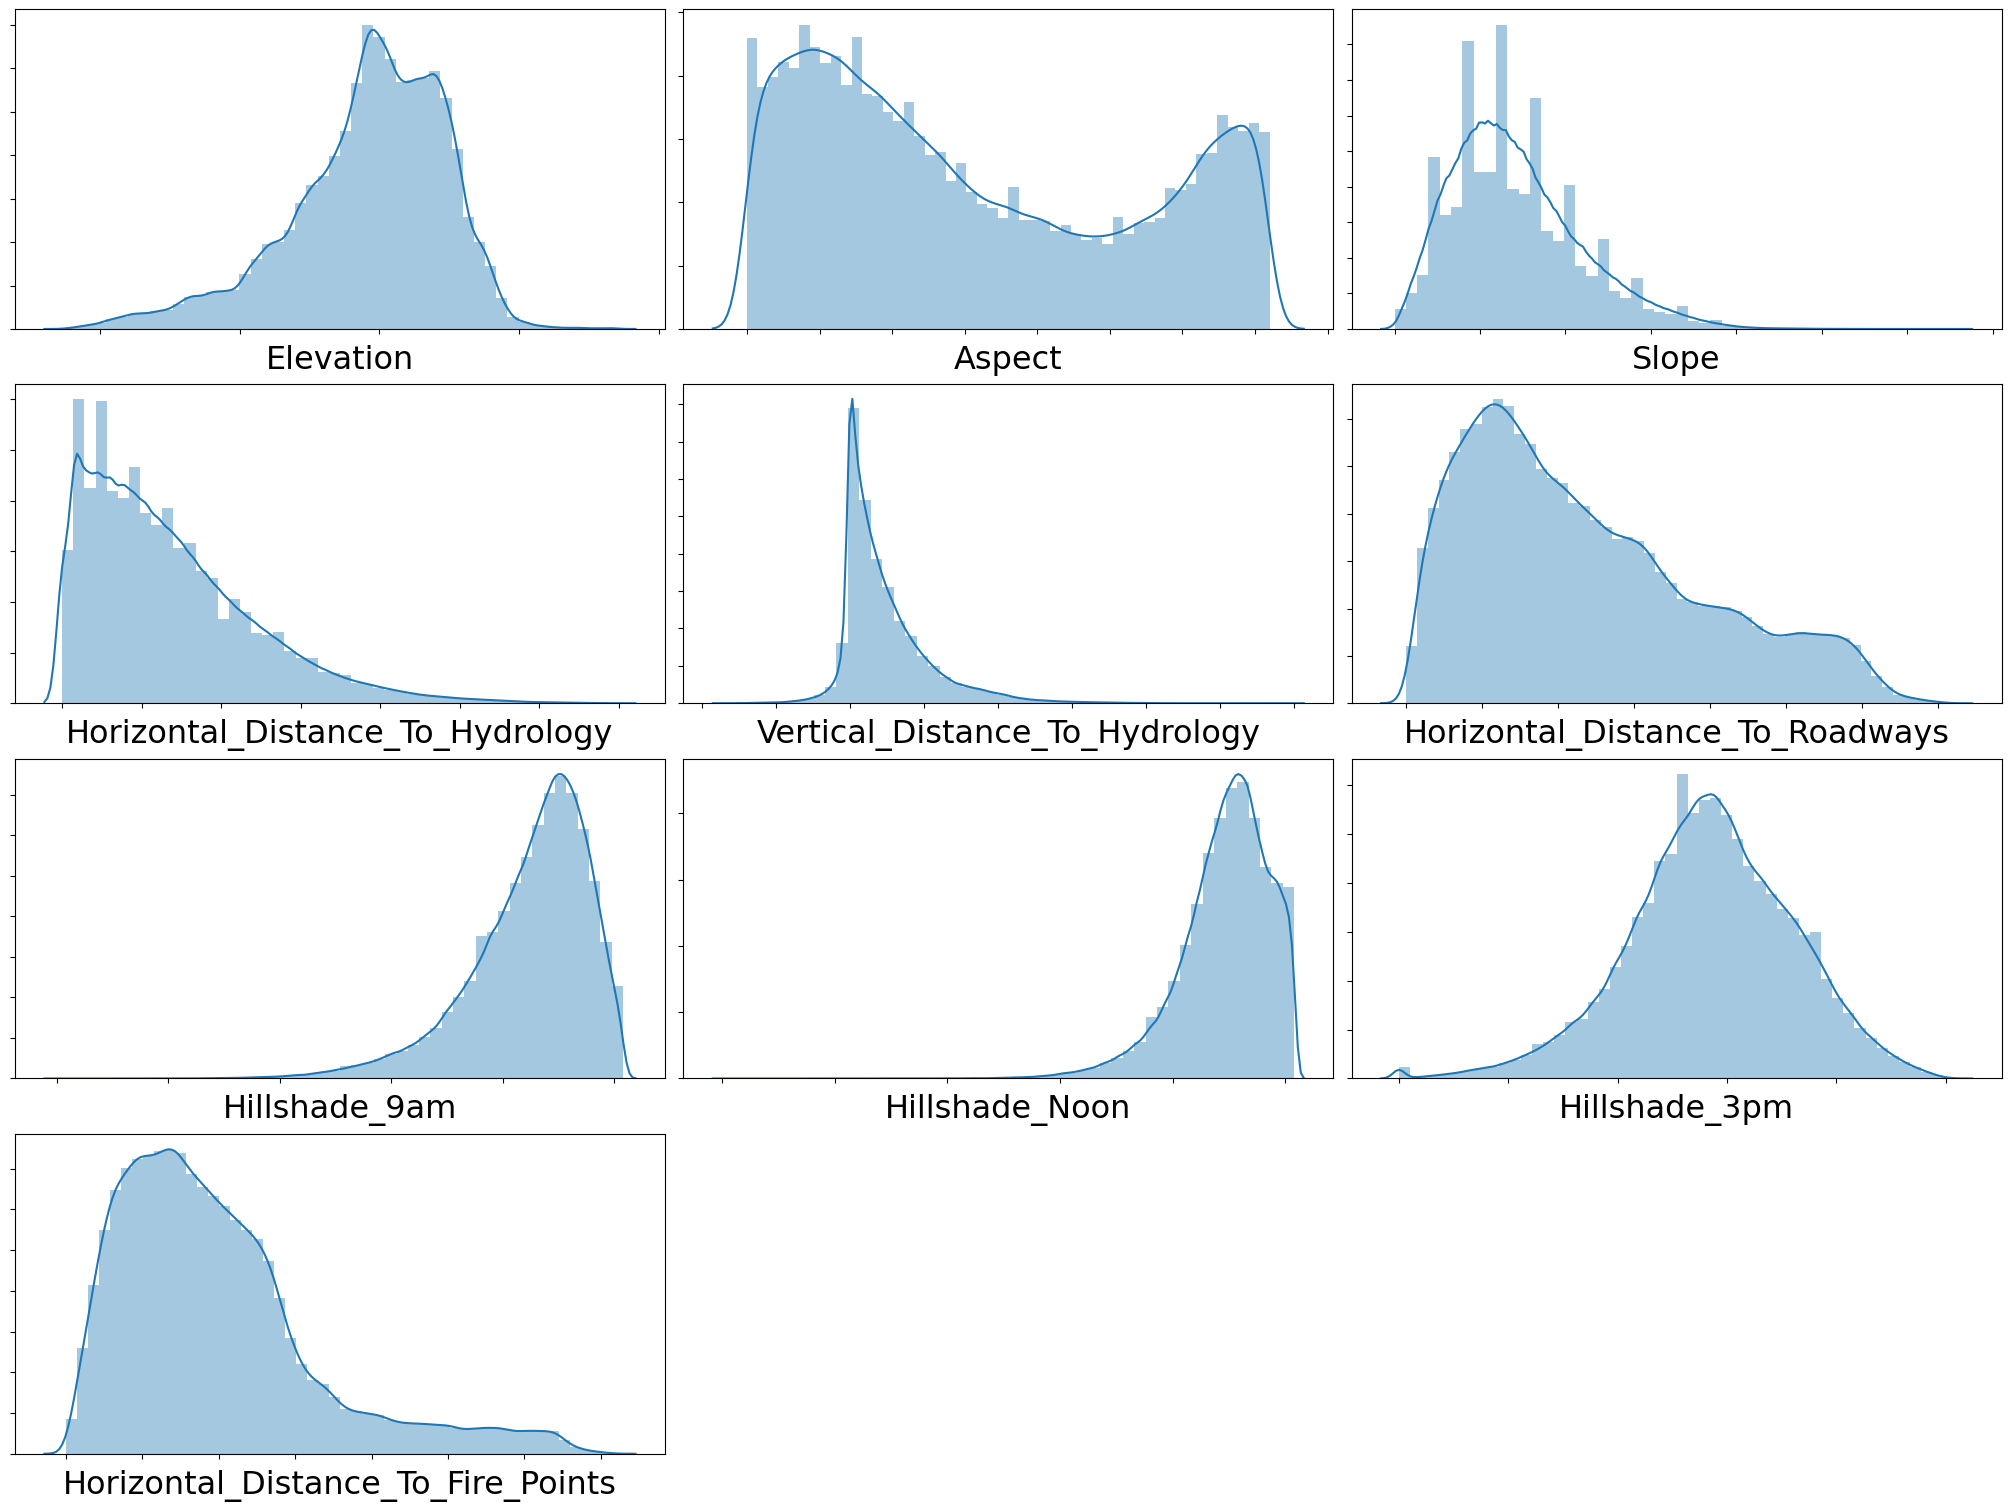

In [ ]:
%%time
#Grafico las variables continuas
warnings.filterwarnings('ignore')
#para ignorar unos avisos que indican que sns.distplot va a ser quitada en versiones futuras de seaborn
#si da fallo es porque en la version de seaborn instalada ya non existe
fig = plt.figure(figsize=(20,15),layout='constrained')
for i, col in enumerate(cont_data.columns):
    ax = fig.add_subplot(4,3,i+1)
    sns.distplot(cont_data[col], ax = ax)
    ax.set_xlabel(col,fontsize = 23)
    ax.set_ylabel("")
    ax.set_yticklabels([])
    ax.set_xticklabels([])

Compruebo las correlacións de los parámetros continuos junto con el Cover_Type

<AxesSubplot: >

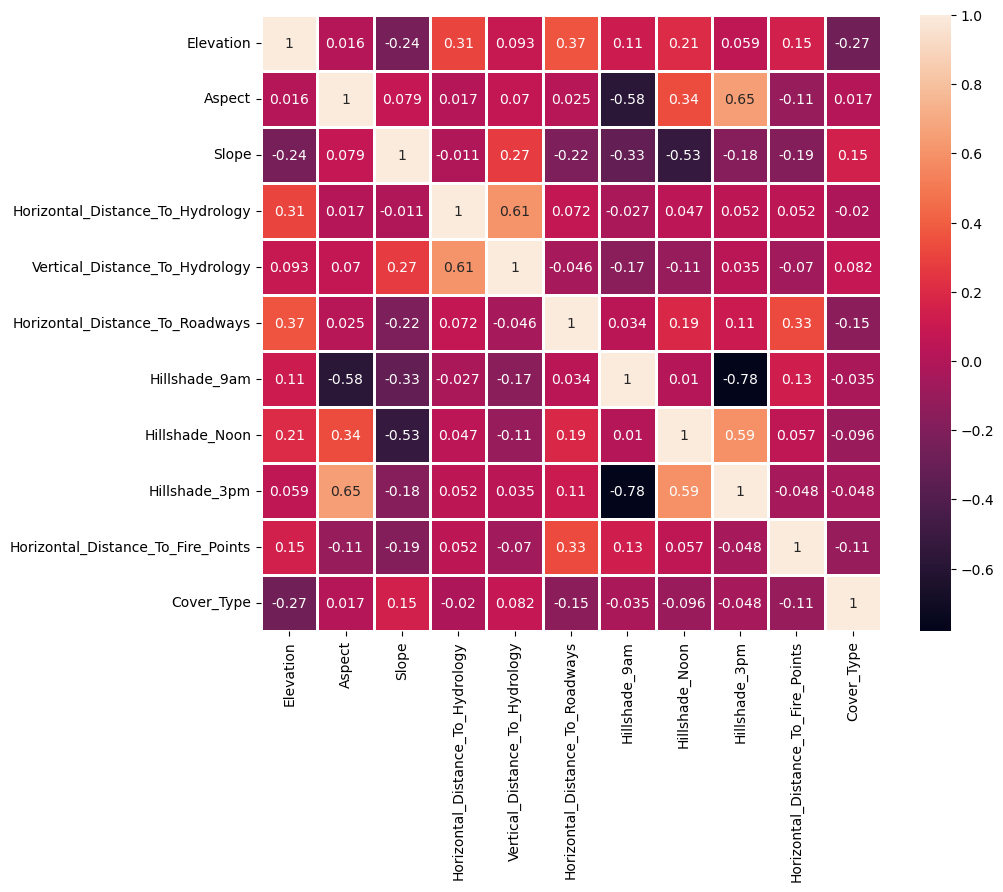

In [ ]:
plt.figure(figsize=(10,8))

sns.heatmap(cont_data_cover.corr(),linecolor='white',linewidths=1,annot=True, xticklabels = True, yticklabels= True)

Grafico distribución covertypes por wilderness area. Para esto dado que son variables binarias voy a agrupar los 4 tipos de area silvestre en una sola columna a partir de un bucle for que vaya contando las columnas en las que el valor es 1 (presencia). Finalmente esta columna la añado al dataset copia df que creé antes.

In [ ]:
def rev_code(row):
    for c in Wilderness_data.columns:
        if row[c]==1:
            return c

df['Wilderness_Type']=Wilderness_data.apply(rev_code, axis=1)

Text(0, 0.5, 'Contas')

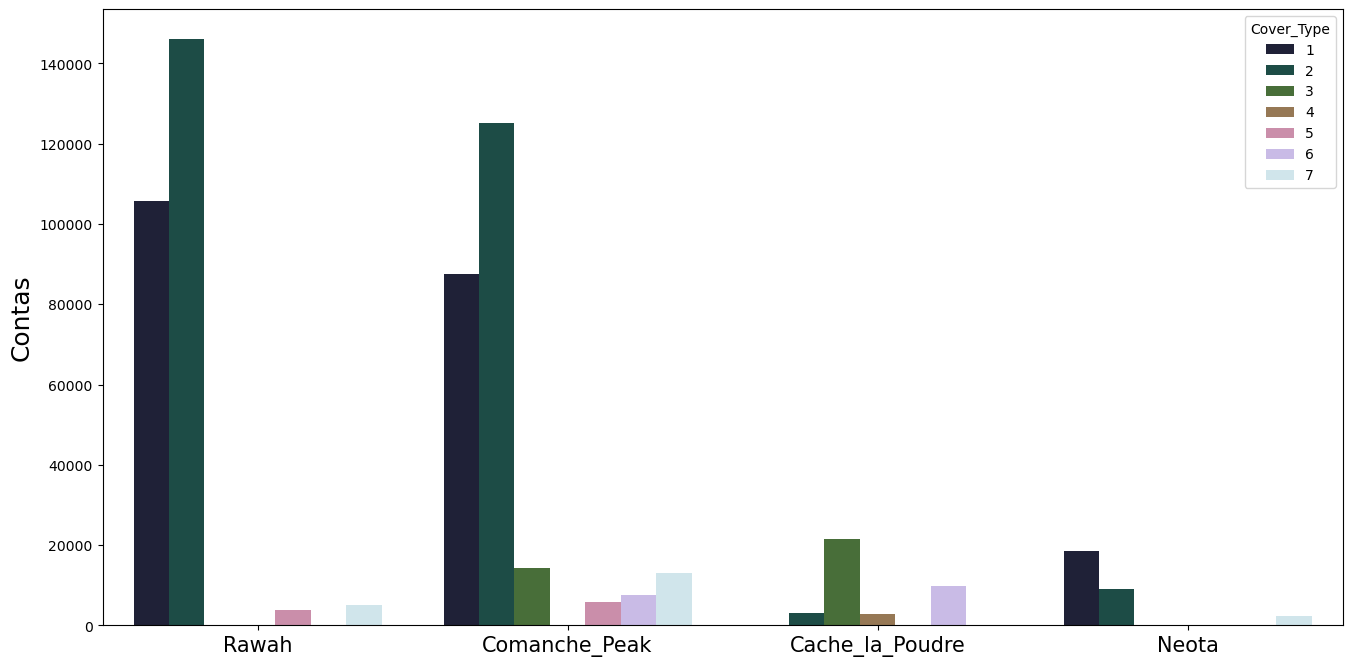

In [ ]:
plt.figure(figsize=(16,8))
sns.countplot(x='Wilderness_Type', hue='Cover_Type',data=df, palette="cubehelix")
plt.xticks(rotation=0, fontsize = 15)
plt.xlabel("")
plt.ylabel("Contas", fontsize = 18)

Hacemos lo mismo para el tipo de suelo.

In [ ]:
#TIEMPO DE EJECUCIÓN ALGO PROLONGDO!
def rev_code(row):
    for c in Soil_data.columns:
        if row[c]==1:
            return c

df['Soil_Type']=Soil_data.apply(rev_code, axis=1)

Text(0, 0.5, 'Contas')

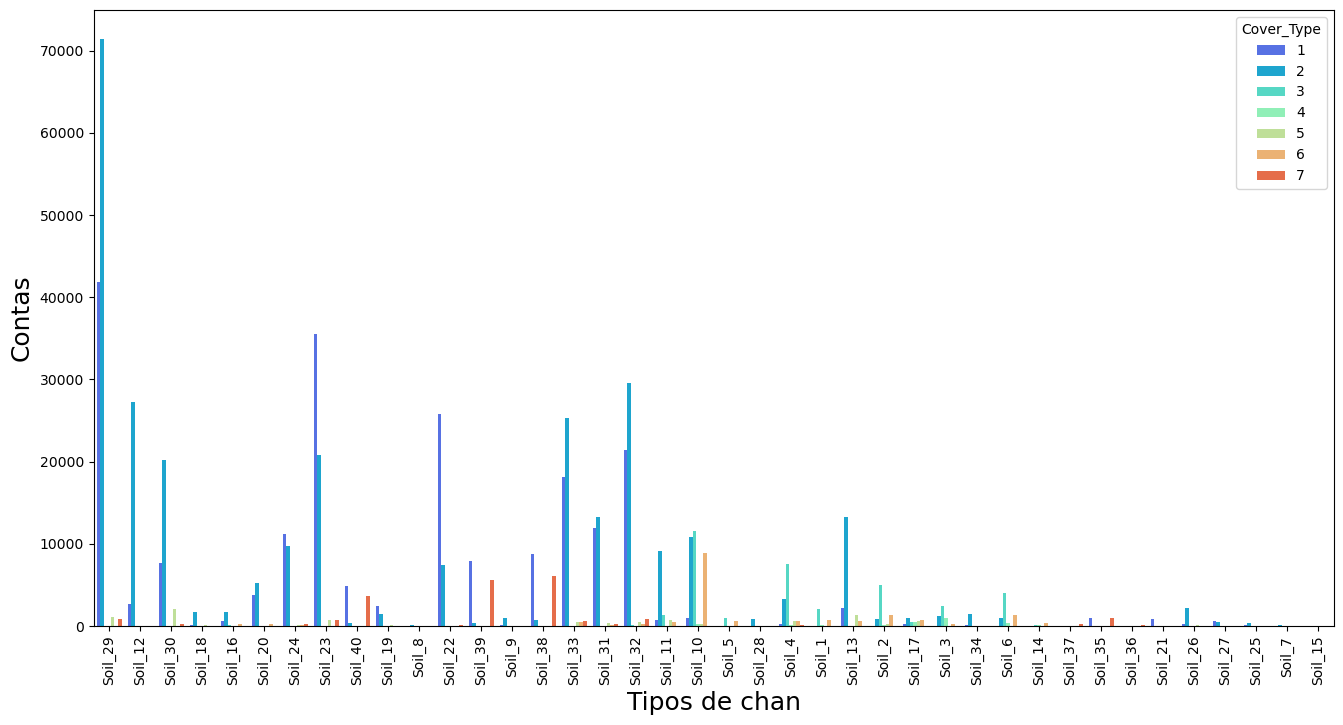

In [ ]:
plt.figure(figsize=(16,8))
sns.countplot(x='Soil_Type', hue='Cover_Type',data=df, palette="rainbow")
plt.xticks(rotation=90)
plt.xlabel("Tipos de chan", fontsize = 18)
plt.ylabel("Contas", fontsize = 18)

Vemos que hay muchos Soil_# que a penas tienen ejemplares. Vamos a comprobar cuáles tienen menos de 1000 (si estuviesen distribuidos por igual, cada uno debería tener alrededor de 14mil)

In [ ]:
print('Soil Type',' Contas')
for col in binary_data:
    count=binary_data[col].value_counts()[1]
    if count < 1000:
        print(col,count)

Soil Type  Contas
Soil_7 105
Soil_8 179
Soil_14 599
Soil_15 3
Soil_21 838
Soil_25 474
Soil_28 946
Soil_36 119
Soil_37 298


## Inciso: Gráfica sobre SVM para el trabajo

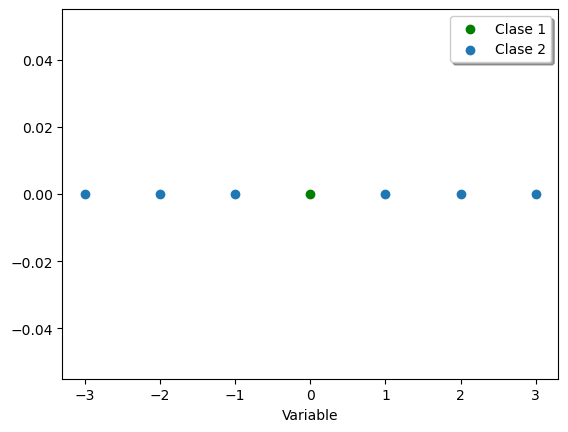

In [ ]:
fig = plt.figure()
a = 0
b = 0
x = [-3,-2,-1,1,2,3]
y = [0,0,0,0,0,0]
plt.scatter(a,b,c = "green", label = "Clase 1")
plt.scatter(x,y, label = "Clase 2")
plt.xlabel("Variable")
plt.legend(shadow=True)

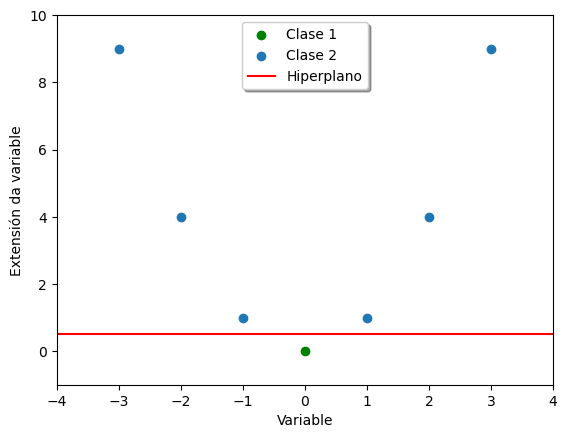

In [ ]:
fig = plt.figure()
a = 0
b = 0
x = [-3,-2,-1,1,2,3]
y = [9,4,1,1,4,9]
plt.scatter(a,b,c = "green", label = "Clase 1")
plt.scatter(x,y, label = "Clase 2")
z1 = [-5,5]
z2 = [0.5,0.5]
plt.plot(z1,z2, "r", label = "Hiperplano")
plt.xlabel("Variable")
plt.ylabel("Extensión da variable")
plt.xlim(-4,4)
plt.ylim(-1,10)
plt.legend(shadow=True)

# Tratamiento de los datos
## Separo dataset en: dataset atributos y dataset clases
### NOTA: Esta parte sí es necesario ejecutarla en el caso de querer ejecutar los algoritmos de ML a posteriori
A pesar de existir métodos de feature selection para reducir la dimensionalidad, vamos hacerlo manualmente para aprovechar el análisis estadístico que hemos hecho.

In [ ]:
x = data.iloc[:,:-1]
y = data.iloc[:,-1]
df = x.copy() #Creamos copia

## Reducimos dimensionalidad

In [ ]:
#Ponemos en una lista parámetros a borrar y los borramos del dataset
rem=['Hillshade_3pm','Soil_7','Soil_8','Soil_14','Soil_15','Soil_21','Soil_25','Soil_28','Soil_36','Soil_37']
df.drop(rem,axis=1,inplace=True)
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,Rawah,...,Soil_29,Soil_30,Soil_31,Soil_32,Soil_33,Soil_34,Soil_35,Soil_38,Soil_39,Soil_40
0,2596,51,3,258,0,510,221,232,6279,1,...,1,0,0,0,0,0,0,0,0,0
1,2590,56,2,212,-6,390,220,235,6225,1,...,1,0,0,0,0,0,0,0,0,0
2,2804,139,9,268,65,3180,234,238,6121,1,...,0,0,0,0,0,0,0,0,0,0
3,2785,155,18,242,118,3090,238,238,6211,1,...,0,1,0,0,0,0,0,0,0,0
4,2595,45,2,153,-1,391,220,234,6172,1,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,837,0,...,0,0,0,0,0,0,0,0,0,0
581008,2391,152,19,67,12,95,240,237,845,0,...,0,0,0,0,0,0,0,0,0,0
581009,2386,159,17,60,7,90,236,241,854,0,...,0,0,0,0,0,0,0,0,0,0
581010,2384,170,15,60,5,90,230,245,864,0,...,0,0,0,0,0,0,0,0,0,0


**IMPORTANTE**: De este modo tendremos el DataFrame *data* que se corresponde con el original sein modificaciones y *df* que se corresponde con que le haremos distintas cosas.

## Normalizamos los datos

Comprobamos si en nuestros datos hay valores negativos:

In [ ]:
print("Negative values?")
for col in df.columns:
    print(col,":",(df[col] < 0).values.any())

Negative values?
Elevation : False
Aspect : False
Slope : False
Horizontal_Distance_To_Hydrology : False
Vertical_Distance_To_Hydrology : True
Horizontal_Distance_To_Roadways : False
Hillshade_9am : False
Hillshade_Noon : False
Horizontal_Distance_To_Fire_Points : False
Rawah : False
Neota : False
Comanche_Peak : False
Cache_la_Poudre : False
Soil_1 : False
Soil_2 : False
Soil_3 : False
Soil_4 : False
Soil_5 : False
Soil_6 : False
Soil_9 : False
Soil_10 : False
Soil_11 : False
Soil_12 : False
Soil_13 : False
Soil_16 : False
Soil_17 : False
Soil_18 : False
Soil_19 : False
Soil_20 : False
Soil_22 : False
Soil_23 : False
Soil_24 : False
Soil_26 : False
Soil_27 : False
Soil_29 : False
Soil_30 : False
Soil_31 : False
Soil_32 : False
Soil_33 : False
Soil_34 : False
Soil_35 : False
Soil_38 : False
Soil_39 : False
Soil_40 : False
Cover_Type : False


La columna Vertical_Distance_To_Hydrology contiene valores negativos. Vamos a normalizar los parámetros continuos. De este modo lidiamos con valores negativos al mismo tiempo que optimizamos nuestros datos para alguno de los algoritmos de ML.

In [ ]:
#Redefinimos el DataFrame con las variables continuas usando df
#pues ahora tenemos una columna menos aquí. Aprovechamos para redefinir el resto de subsets.
cont_df=df.loc[:,'Elevation':'Horizontal_Distance_To_Fire_Points']

binary_df=df.loc[:,'Rawah':'Soil_40']

Wilderness_df=df.loc[:,'Rawah': 'Cache_la_Poudre']

Soil_df=df.loc[:,'Soil_1':'Soil_40']

In [ ]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(cont_df)
scaled = scaler.fit_transform(cont_df)
scaled_cont_df = pd.DataFrame(scaled, columns = cont_df.columns)
scaled_cont_df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points
0,0.368684,0.141667,0.045455,0.184681,0.223514,0.071659,0.870079,0.913386,0.875366
1,0.365683,0.155556,0.030303,0.151754,0.215762,0.054798,0.866142,0.925197,0.867838
2,0.472736,0.386111,0.136364,0.191840,0.307494,0.446817,0.921260,0.937008,0.853339
3,0.463232,0.430556,0.272727,0.173228,0.375969,0.434172,0.937008,0.937008,0.865886
4,0.368184,0.125000,0.030303,0.109520,0.222222,0.054939,0.866142,0.921260,0.860449
...,...,...,...,...,...,...,...,...,...
581007,0.268634,0.425000,0.303030,0.060845,0.245478,0.015175,0.944882,0.933071,0.116688
581008,0.266133,0.422222,0.287879,0.047960,0.239018,0.013348,0.944882,0.933071,0.117803
581009,0.263632,0.441667,0.257576,0.042949,0.232558,0.012646,0.929134,0.948819,0.119058
581010,0.262631,0.472222,0.227273,0.042949,0.229974,0.012646,0.905512,0.964567,0.120452


## Asimetría
Miramos que asimetría tenemos.

In [ ]:
print(scaled_cont_df.skew())

Elevation                            -0.817596
Aspect                                0.402628
Slope                                 0.789273
Horizontal_Distance_To_Hydrology      1.140437
Vertical_Distance_To_Hydrology        1.790250
Horizontal_Distance_To_Roadways       0.713679
Hillshade_9am                        -1.181147
Hillshade_Noon                       -1.063056
Horizontal_Distance_To_Fire_Points    1.288644
dtype: float64


Probamos con distintas transformaciones a los datos para ver si conseguimos reducir la asimetría.

In [ ]:
scaled_symm_df = scaled_cont_df.apply(lambda x: np.log(x+1) )
scaled_symm_df.skew()

Elevation                            -1.132227
Aspect                                0.198002
Slope                                 0.540999
Horizontal_Distance_To_Hydrology      0.813444
Vertical_Distance_To_Hydrology        1.487727
Horizontal_Distance_To_Roadways       0.458337
Hillshade_9am                        -1.430735
Hillshade_Noon                       -1.275665
Horizontal_Distance_To_Fire_Points    0.910360
dtype: float64

In [ ]:
scaled_symm_df = scaled_cont_df.apply(lambda x: np.sqrt(x) )
scaled_symm_df.skew()

Elevation                            -1.454957
Aspect                               -0.139423
Slope                                 0.024459
Horizontal_Distance_To_Hydrology      0.006737
Vertical_Distance_To_Hydrology        1.192307
Horizontal_Distance_To_Roadways       0.096721
Hillshade_9am                        -1.540718
Hillshade_Noon                       -1.370527
Horizontal_Distance_To_Fire_Points    0.416731
dtype: float64

In [ ]:
scaled_symm_df = scaled_cont_df.apply(lambda x: np.cbrt(x) )
scaled_symm_df.skew()

Elevation                            -1.751897
Aspect                               -0.510421
Slope                                -0.344194
Horizontal_Distance_To_Hydrology     -0.746315
Vertical_Distance_To_Hydrology        0.981763
Horizontal_Distance_To_Roadways      -0.174927
Hillshade_9am                        -1.808264
Hillshade_Noon                       -1.653883
Horizontal_Distance_To_Fire_Points    0.078862
dtype: float64

## Subconjuntos entrenamiento y testeo para algoritmos de ML
Creo estes subconjuntos tanto para el dataset después de tratar como el dataset primitivo en bruto.

In [ ]:
#Dataset bruto
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

#Dataset tratado
X = pd.concat([scaled_cont_df,binary_df], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#SUPPORT VECTOR MACHINE
#Dataset tratado con un conjunto de entrenamiento algo más pequeño
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X, y, test_size=0.5, random_state=0)

#NAIVE BAYES
#Dataset variables continuas tratado
X2_train, X2_test, Y2_train, Y2_test = train_test_split(scaled_cont_df, y, test_size=0.3, random_state=0)
#Dataset variables discretas tratado
X3_train, X3_test, Y3_train, Y3_test = train_test_split(binary_df, y, test_size=0.3, random_state=0)

## Desbalance de clases
Vamos a tratar de corregir el desbalance de clases, voy a aplicar SMOTE. Dado que esto se debe de aplicar sólo a los datasets de entrenamiento, he hecho antes el split
### NOTA: CUIDADO AL EJECUTAR! LLEVA MUCHO TIEMPO!

In [ ]:
%%time
smot = SMOTE()
X_smote, Y_smote = smot.fit_resample(X_train,Y_train)

CPU times: total: 11min 38s
Wall time: 7min 35s


<AxesSubplot: xlabel='Cover_Type', ylabel='Contas'>

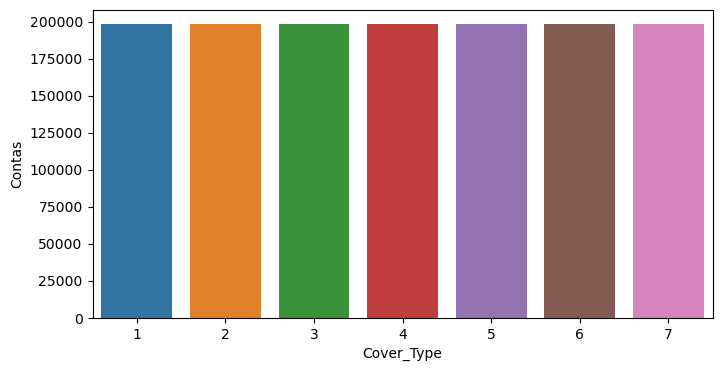

In [ ]:
smote = pd.concat([X_smote,Y_smote], axis = 1)
class_dist=smote.groupby('Cover_Type').size()
class_label=pd.DataFrame(class_dist,columns=['Contas'])
plt.figure(figsize=(8,4))
sns.barplot(x=class_label.index,y=class_label.Contas,data=class_label)

Selecciono ahora de los datasets tratados y balanceados las variables continuas y las discretas.

In [ ]:
cont_smote = X_smote.loc[:,'Elevation':'Horizontal_Distance_To_Fire_Points']
binary_smote = X_smote.loc[:,'Rawah':'Soil_40']

# Aplicación de modelos de Machine Learning

## Random Forest
Imos facer el ajuste tanto para el dataset tratado como para el bruto

In [ ]:
%%time
RFC = RandomForestClassifier()
RFC.fit(X_train,Y_train)
RFC.score(X_test,Y_test)

CPU times: total: 1min 43s
Wall time: 1min 43s


0.9559562603267854

Vamos a ver cuánto se diferencia si usamos como DataFrame el *data*.

In [ ]:
%%time
RFC2 = RandomForestClassifier()
RFC2.fit(x_train,y_train)
RFC2.score(x_test,y_test)

CPU times: total: 1min 50s
Wall time: 1min 51s


0.9526689003120984

Ahora con el dataset tratado y aumentado con SMOTE

In [ ]:
%%time
RFC3 = RandomForestClassifier()
RFC3.fit(X_smote, Y_smote)
RFC3.score(X_test,Y_test)

CPU times: total: 8min 30s
Wall time: 8min 32s


0.959117404075638

Vemos que tenemos una diferencia ínfima de mejora, lo cuál tiene sentido pues los árboles de decisión y por lo tanto los random forest están especializados en datasets desbalanceados. Graficamos la importancia en ambos casos de cada parámetro.

<BarContainer object of 44 artists>

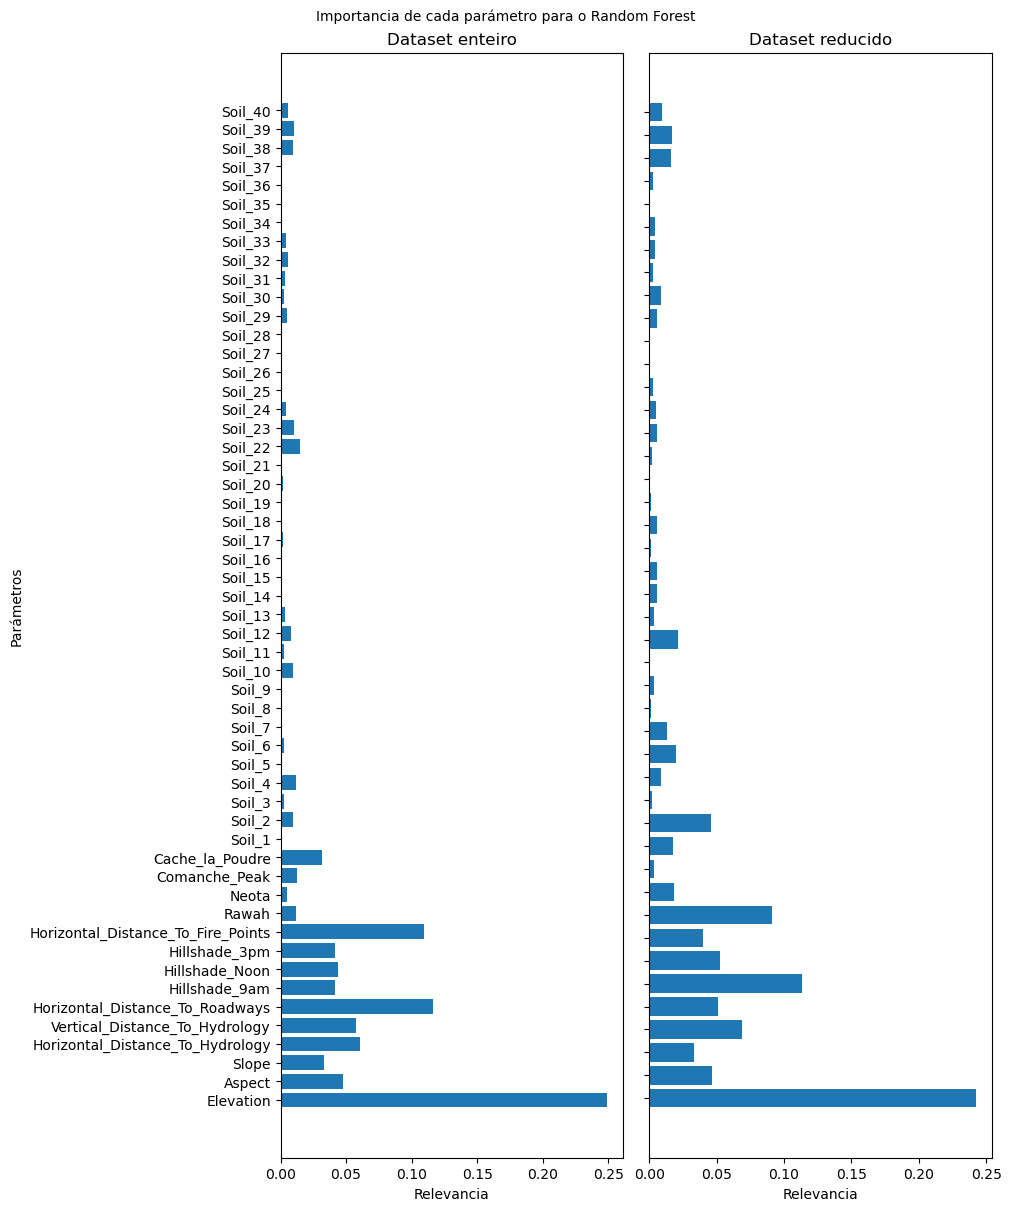

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,12),layout='constrained')
fig.suptitle('Importancia de cada parámetro para o Random Forest',fontsize=10)
axs[0].set_title('Dataset enteiro')
axs[1].set_title('Dataset reducido')
for ax in axs.flat:
    ax.set(xlabel='Relevancia', ylabel='Parámetros')
    ax.label_outer()

feat_dt1 = RFC2.feature_importances_
feat_dt2 = RFC3.feature_importances_

axs[0].barh(x_train.columns.values, feat_dt1)
axs[1].barh(X_smote.columns.values, feat_dt2)

Vemos que no hay diferencia en términos prácticos. Obtenemos la mtriz de confusión.

In [ ]:
Y_pred = RFC3.predict(X_test)
confusion_matrix(Y_test,Y_pred)

array([[60543,  2626,     3,     0,    46,    22,   258],
       [ 2101, 82187,   293,     0,   350,   222,    45],
       [    1,    68, 10199,    79,    20,   214,     0],
       [    0,     0,    59,   746,     0,    17,     0],
       [   12,   200,    13,     0,  2615,    10,     0],
       [    1,    55,   232,    31,     1,  4909,     0],
       [  128,    17,     0,     0,     2,     0,  5979]], dtype=int64)

In [ ]:
print(classification_report(Y_test, Y_pred, target_names=["Clase 1","Clase 2","Clase 3","Clase 4","Clase 5","Clase 6","Clase 7"]))

              precision    recall  f1-score   support

     Clase 1       0.96      0.95      0.96     63498
     Clase 2       0.97      0.96      0.96     85198
     Clase 3       0.94      0.96      0.95     10581
     Clase 4       0.87      0.91      0.89       822
     Clase 5       0.86      0.92      0.89      2850
     Clase 6       0.91      0.94      0.92      5229
     Clase 7       0.95      0.98      0.96      6126

    accuracy                           0.96    174304
   macro avg       0.92      0.95      0.93    174304
weighted avg       0.96      0.96      0.96    174304



## Support Vector Machine

Aparentemente nuestro dataset tiene demasiadas muestras como para que el entrenamento pueda tardar algo razonable con parámetros predeterminados. Pruebo a usar una variante de SVC que usa un kernel distinto que debería ir mejor con nuestro dataset.

In [ ]:
%%time
lsvc = LinearSVC()
lsvc.fit(X_smote,Y_smote)
lsvc.score(X_test,Y_test)

CPU times: total: 4min 13s
Wall time: 4min 14s


0.5436995134936662

Debido al elevado número de mostras la precisión acaba bajando. Pruebo con el dataset desbalanceado.

In [ ]:
%%time
lsvc = LinearSVC()
lsvc.fit(X_train,Y_train)
lsvc.score(X_test,Y_test)

CPU times: total: 59.9 s
Wall time: 1min


0.7110049109601616

In [ ]:
Y_pred = lsvc.predict(X_test)
print(classification_report(Y_test, Y_pred, target_names=["Clase 1","Clase 2","Clase 3","Clase 4","Clase 5","Clase 6","Clase 7"]))

              precision    recall  f1-score   support

     Clase 1       0.70      0.68      0.69     63498
     Clase 2       0.74      0.79      0.76     85198
     Clase 3       0.61      0.88      0.72     10581
     Clase 4       0.68      0.24      0.36       822
     Clase 5       0.44      0.01      0.02      2850
     Clase 6       0.38      0.03      0.06      5229
     Clase 7       0.69      0.51      0.58      6126

    accuracy                           0.71    174304
   macro avg       0.60      0.45      0.46    174304
weighted avg       0.70      0.71      0.69    174304



Vemos que el resultado cambia radicalmente. Voy a probar además con otra variante que usa descenso de gradiente.

In [ ]:
%%time
sgdc = SGDClassifier()
sgdc.fit(X_smote,Y_smote)
sgdc.score(X_test,Y_test)

CPU times: total: 19.2 s
Wall time: 19.2 s


0.46249655773820453

Debido al elevado número de muestras que genera SMOTE, voy a probar con el dataset modificado pero sin tener corregido el desbalance de clases.

In [ ]:
%%time
sgdc = SGDClassifier()
sgdc.fit(X_train,Y_train)
sgdc.score(X_test,Y_test)

CPU times: total: 5.91 s
Wall time: 5.88 s


0.7085264824674132

In [ ]:
Y_pred = sgdc.predict(X_test)
print(classification_report(Y_test, Y_pred, target_names=["Clase 1","Clase 2","Clase 3","Clase 4","Clase 5","Clase 6","Clase 7"]))

              precision    recall  f1-score   support

     Clase 1       0.70      0.69      0.70     63498
     Clase 2       0.74      0.79      0.76     85198
     Clase 3       0.59      0.89      0.71     10581
     Clase 4       0.51      0.08      0.14       822
     Clase 5       0.29      0.01      0.02      2850
     Clase 6       0.09      0.01      0.01      5229
     Clase 7       0.67      0.47      0.55      6126

    accuracy                           0.71    174304
   macro avg       0.51      0.42      0.41    174304
weighted avg       0.69      0.71      0.69    174304



Vemos que hay un resultado muy parecido. Sin embargo, hay un enorme diferencia en tiempo de ejecución. Se pasó de 1 minuto a 5 segundos.

## Naive Bayes Classifier
Vamos a usar sklearn.naive_bayes.GaussianNB, por lo que vamos a usar las variables continuas normalizadas para que se asemejen lo máximo posible a distribuciones normales con las que trabaja este algoritmo.

In [ ]:
%%time
gnb = GaussianNB()
gnb.fit(cont_smote,Y_smote)
gnb.score(X2_test,Y2_test)

CPU times: total: 531 ms
Wall time: 537 ms


0.46141224527262714

In [ ]:
%%time
gnb = GaussianNB()
gnb.fit(X2_train,Y2_train)
gnb.score(X2_test,Y2_test)

CPU times: total: 359 ms
Wall time: 577 ms


0.6352980998714889

In [ ]:
Y2_pred = gnb.predict(X2_test)
confusion_matrix(Y2_test,Y2_pred)

array([[42997, 16175,   448,     0,   243,   180,  3455],
       [20604, 56640,  3900,     3,  1179,  1711,  1161],
       [    0,  1982,  7228,   282,     3,  1086,     0],
       [    0,     0,   351,   349,     0,   122,     0],
       [    0,  2204,   166,     0,   432,    48,     0],
       [    0,   901,  2689,   103,    15,  1521,     0],
       [ 4497,    35,    26,     0,     0,     0,  1568]], dtype=int64)

In [ ]:
print(classification_report(Y2_test, Y2_pred, target_names=["Clase 1","Clase 2","Clase 3","Clase 4","Clase 5","Clase 6","Clase 7"]))

              precision    recall  f1-score   support

     Clase 1       0.63      0.68      0.65     63498
     Clase 2       0.73      0.66      0.69     85198
     Clase 3       0.49      0.68      0.57     10581
     Clase 4       0.47      0.42      0.45       822
     Clase 5       0.23      0.15      0.18      2850
     Clase 6       0.33      0.29      0.31      5229
     Clase 7       0.25      0.26      0.25      6126

    accuracy                           0.64    174304
   macro avg       0.45      0.45      0.44    174304
weighted avg       0.64      0.64      0.64    174304



Ahora voy a probar la alternativa con las variables discretas, para ello uso sklearn.naive_bayes.BernoulliNB

In [ ]:
%%time
bnb = BernoulliNB()
bnb.fit(binary_smote,Y_smote)
bnb.score(X3_test,Y3_test)

CPU times: total: 1.59 s
Wall time: 1.54 s


0.45136657793280704

In [ ]:
%%time
bnb = BernoulliNB()
bnb.fit(X3_train,Y3_train)
bnb.score(X3_test,Y3_test)

CPU times: total: 672 ms
Wall time: 556 ms


0.6301748668992105

In [ ]:
Y3_pred = bnb.predict(X3_test)
confusion_matrix(Y3_test,Y3_pred)

array([[29003, 32261,    60,     0,    62,   282,  1830],
       [12984, 66454,  2460,     2,   289,  2689,   320],
       [    0,   387,  9269,   462,    55,   408,     0],
       [    0,     0,   364,   446,     0,    12,     0],
       [  252,  2070,   264,     0,   182,    82,     0],
       [   47,   698,  3210,    43,   200,  1031,     0],
       [ 1744,   892,    33,     0,     0,     0,  3457]], dtype=int64)

In [ ]:
print(classification_report(Y3_test, Y3_pred, target_names=["Clase 1","Clase 2","Clase 3","Clase 4","Clase 5","Clase 6","Clase 7"]))

              precision    recall  f1-score   support

     Clase 1       0.66      0.46      0.54     63498
     Clase 2       0.65      0.78      0.71     85198
     Clase 3       0.59      0.88      0.71     10581
     Clase 4       0.47      0.54      0.50       822
     Clase 5       0.23      0.06      0.10      2850
     Clase 6       0.23      0.20      0.21      5229
     Clase 7       0.62      0.56      0.59      6126

    accuracy                           0.63    174304
   macro avg       0.49      0.50      0.48    174304
weighted avg       0.63      0.63      0.62    174304



## Redes Neuronales

In [ ]:
%%time
RN = MLPClassifier()
RN.fit(x_train,y_train)
RN.score(x_test,y_test)

CPU times: total: 23min 1s
Wall time: 5min 46s


0.7672055718744263

In [ ]:
y_pred = RN.predict(x_test)
confusion_matrix(y_test,y_pred)

array([[47061, 15096,     6,     0,     0,     8,  1327],
       [13932, 69820,   645,     3,    79,   624,    95],
       [    0,   868,  8044,   129,     0,  1540,     0],
       [    0,     1,   113,   622,     0,    86,     0],
       [   30,  2467,    68,     0,   253,    32,     0],
       [    1,   822,  1200,    36,     0,  3170,     0],
       [ 1326,    43,     0,     0,     0,     0,  4757]], dtype=int64)

In [ ]:
print(classification_report(y_test, y_pred, target_names=["Clase 1","Clase 2","Clase 3","Clase 4","Clase 5","Clase 6","Clase 7"]))

              precision    recall  f1-score   support

     Clase 1       0.75      0.74      0.75     63498
     Clase 2       0.78      0.82      0.80     85198
     Clase 3       0.80      0.76      0.78     10581
     Clase 4       0.79      0.76      0.77       822
     Clase 5       0.76      0.09      0.16      2850
     Clase 6       0.58      0.61      0.59      5229
     Clase 7       0.77      0.78      0.77      6126

    accuracy                           0.77    174304
   macro avg       0.75      0.65      0.66    174304
weighted avg       0.77      0.77      0.76    174304



Ahora con el dataset tratado

In [ ]:
%%time
RN2 = MLPClassifier(max_iter = 1000)
RN2.fit(X_train,Y_train)
RN2.score(X_test,Y_test)

CPU times: total: 1h 11min 43s
Wall time: 17min 58s


0.8500263906737654

In [ ]:
Y_pred = RN2.predict(X_test)
confusion_matrix(Y_test,Y_pred)

array([[49274, 13537,     9,     0,   168,    19,   491],
       [ 5446, 78369,   458,     0,   547,   302,    76],
       [    0,   531,  9107,   141,    37,   765,     0],
       [    0,     0,    77,   696,     0,    49,     0],
       [   48,  1037,    48,     0,  1699,    18,     0],
       [   12,   702,   766,    40,     7,  3702,     0],
       [  738,    72,     0,     0,     0,     0,  5316]], dtype=int64)

In [ ]:
print(classification_report(Y_test, Y_pred, target_names=["Clase 1","Clase 2","Clase 3","Clase 4","Clase 5","Clase 6","Clase 7"]))

              precision    recall  f1-score   support

     Clase 1       0.89      0.78      0.83     63498
     Clase 2       0.83      0.92      0.87     85198
     Clase 3       0.87      0.86      0.87     10581
     Clase 4       0.79      0.85      0.82       822
     Clase 5       0.69      0.60      0.64      2850
     Clase 6       0.76      0.71      0.73      5229
     Clase 7       0.90      0.87      0.89      6126

    accuracy                           0.85    174304
   macro avg       0.82      0.80      0.81    174304
weighted avg       0.85      0.85      0.85    174304



Voy a probar con SMOTE,
### NO EJECUTAR!!! TARDA DEMASIADO TIEMPO!!!

In [ ]:
%%time
RN3 = MLPClassifier(max_iter = 2000)
RN3.fit(X_smote,Y_smote)
RN3.score(X_test,Y_test)

CPU times: total: 3h 59min 45s
Wall time: 1h 27s


0.8194476317238847

Tamén empeora el rendimiento.

In [ ]:
datos = [["SVM 1",71.100], ["SVM 2",70.853],["NBC G",63.530],["NBC B",63.017],["MLP 1",76.721],["MLP 2",85.003],["RFC 1", 95.596],["RFC 2",95.912]]
puntuacions = pd.DataFrame(datos, columns = ["Algoritmo", "Puntuación"])
puntuacions

,Algoritmo,Puntuación
0,SVM 1,71.100
1,SVM 2,70.853
2,NBC G,63.530
3,NBC B,63.017
4,MLP 1,76.721
5,MLP 2,85.003
6,RFC 1,95.596
7,RFC 2,95.912


Text(0, 0.5, 'Puntuación (%)')

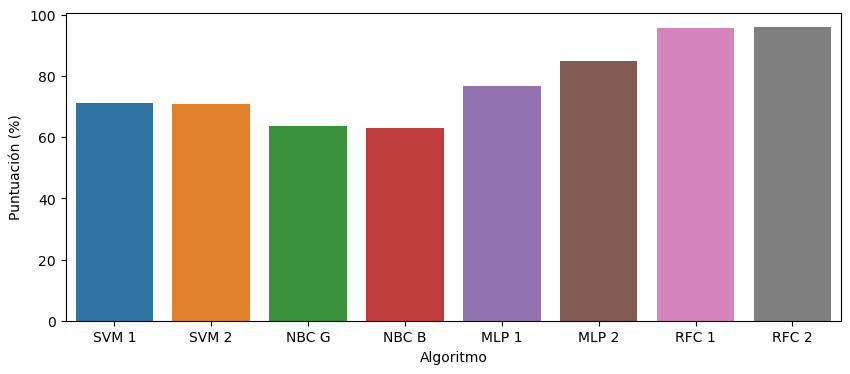

In [ ]:
plt.figure(figsize=(10,4))
sns.barplot(x=puntuacions.Algoritmo,y=puntuacions.Puntuación,data=puntuacions)
plt.ylabel("Puntuación (%)")